# softmax Gluon接口版本实现

In [2]:
import mxnet as mx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  mxnet import gluon
from  mxnet.gluon import data as gdata
from mxnet import autograd
from mxnet.gluon import loss as gloss,nn

## 同理首先准备训练的数据集

In [5]:
context = mx.gpu()

def preproc(X,y):
    return X.astype(np.float32).reshape((-1,28,28))/255 , y  

In [6]:
with context:
    trainData = gdata.vision.FashionMNIST(root='./FashionMNIST',train=True,transform=preproc)
    testData  = gdata.vision.FashionMNIST(root='./FashionMNIST',train=False,transform=preproc)

In [7]:
trainData[0]

(
 [[[0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.        ]
   [0.         0.         0.         0.         0.01568628 0.
    0.         0.         0.         0.      

In [8]:
batch_size = 256
train_iter = gdata.DataLoader(trainData,batch_size,shuffle=True)
test_iter  =gdata.DataLoader(testData,batch_size,shuffle=False)

In [9]:
for X,y in train_iter:
    break
print(y)


[4 6 2 2 7 2 1 5 2 9 9 2 7 6 0 0 3 3 8 3 4 1 2 3 8 2 1 4 9 8 3 7 9 3 0 1 6
 2 7 4 6 7 2 3 8 8 3 4 3 6 1 3 1 0 6 1 9 3 4 9 2 7 7 7 3 6 7 2 7 4 7 4 6 2
 3 3 1 9 5 9 1 1 1 8 6 9 2 1 6 4 7 9 7 5 2 6 8 8 0 7 6 6 3 0 4 5 1 2 2 6 4
 4 4 5 3 4 0 1 9 7 1 0 0 1 9 1 7 3 8 2 7 8 1 9 9 5 7 6 9 0 8 3 1 0 1 9 4 8
 4 5 9 8 5 7 0 6 3 1 2 9 9 9 0 5 9 1 1 4 4 5 3 3 7 4 8 0 7 1 4 0 2 0 9 3 5
 5 1 0 2 2 8 8 6 9 8 5 3 1 1 4 0 3 0 1 6 5 3 1 6 9 0 8 2 8 7 4 2 9 6 3 0 6
 7 5 4 5 7 6 0 1 4 5 0 2 9 4 5 3 0 3 1 6 6 1 3 0 8 5 1 7 4 6 5 4 6 6]
<NDArray 256 @cpu(0)>


## 编写获取标签的函数

In [10]:
def get_fashion_mnist_labels(labels):
    test_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [test_labels[int(i)] for i in labels]

In [13]:
print(get_fashion_mnist_labels(y.asnumpy()))

['coat', 'shirt', 'pullover', 'pullover', 'sneaker', 'pullover', 'trouser', 'sandal', 'pullover', 'ankle boot', 'ankle boot', 'pullover', 'sneaker', 'shirt', 't-shirt', 't-shirt', 'dress', 'dress', 'bag', 'dress', 'coat', 'trouser', 'pullover', 'dress', 'bag', 'pullover', 'trouser', 'coat', 'ankle boot', 'bag', 'dress', 'sneaker', 'ankle boot', 'dress', 't-shirt', 'trouser', 'shirt', 'pullover', 'sneaker', 'coat', 'shirt', 'sneaker', 'pullover', 'dress', 'bag', 'bag', 'dress', 'coat', 'dress', 'shirt', 'trouser', 'dress', 'trouser', 't-shirt', 'shirt', 'trouser', 'ankle boot', 'dress', 'coat', 'ankle boot', 'pullover', 'sneaker', 'sneaker', 'sneaker', 'dress', 'shirt', 'sneaker', 'pullover', 'sneaker', 'coat', 'sneaker', 'coat', 'shirt', 'pullover', 'dress', 'dress', 'trouser', 'ankle boot', 'sandal', 'ankle boot', 'trouser', 'trouser', 'trouser', 'bag', 'shirt', 'ankle boot', 'pullover', 'trouser', 'shirt', 'coat', 'sneaker', 'ankle boot', 'sneaker', 'sandal', 'pullover', 'shirt', 'ba

## 显示图片

In [16]:
def show_fashion_mnist(images,labels):
    _,figs = plt.subplots(nrows=1,ncols=len(images),figsize=(12,12))
    for f,img,lab in zip(figs,images,labels):
        f.imshow(img.reshape(28,28).asnumpy())
        f.set_title(lab)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

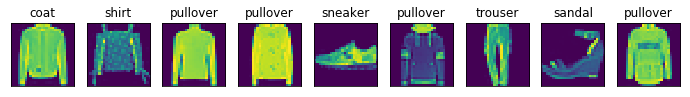

In [19]:
show_fashion_mnist(X[0:9],get_fashion_mnist_labels(y[0:9].asnumpy()))

## 定义和初始化模型

In [20]:
net = nn.Sequential()   #首先定义一个容器

In [21]:
net.add(nn.Dense(10))    #加入一个输出层

In [22]:
from mxnet import init
with context:
    net.initialize(init.Normal(sigma=0.01),) #初始化参数的权重

##  定义损失函数

In [23]:
loss = gloss.SoftmaxCrossEntropyLoss()

## 定义优化算法

In [24]:
trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.1})

In [26]:
def accuracy(y_hat,y):
     return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

def evaluate_accuracy(data_iter,net):
    acc = 0
    for X,y in data_iter:
        acc += accuracy(net(X),y)
    return acc / len(data_iter)

## 训练模型

In [30]:
num_epochs = 5


def train_softmax(net,train_iter,test_iter,loss,num_epochs,
                  batch_size,params=None ,lr=None,trainer=None):
    for epoch in range(0,num_epochs):
        #取出minibatch数据
        train_l = 0
        train_acc = 0
        for X,y in train_iter:
            with autograd.record():
                y_hat = net(X)      #前向运算
                l = loss(y_hat,y)   #计算损失
            l.backward()            #bp算法反向传播
            
            #下面进行训练
            trainer.step(batch_size)
            
            #计算损失和准确率
            train_l += l.mean().asscalar()
            train_acc += accuracy(y_hat,y)
        
        test_acc = evaluate_accuracy(test_iter,net)
        
        print('epoch %d ,loss %.4f , train acc %.3f , test acc %.3f'
              %(epoch+1,train_l/len(train_iter),train_acc/len(train_iter),test_acc))

In [31]:
with context:
    train_softmax(net,train_iter,test_iter,loss,num_epochs,batch_size,None,None,trainer)

epoch 1 ,loss 0.5741 , train acc 0.812 , test acc 0.824
epoch 2 ,loss 0.5292 , train acc 0.824 , test acc 0.833
epoch 3 ,loss 0.5049 , train acc 0.830 , test acc 0.833
epoch 4 ,loss 0.4894 , train acc 0.836 , test acc 0.837
epoch 5 ,loss 0.4783 , train acc 0.838 , test acc 0.845


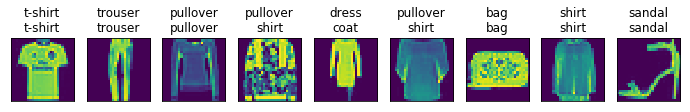

In [37]:
for X,y in test_iter:
    break

true_labels = get_fashion_mnist_labels(y[0:9].asnumpy())
pred_labels = get_fashion_mnist_labels(np.argmax(net(X[0:9]).asnumpy(),axis=1))

my_labels = [true_lab + '\n'+ pred_lab for true_lab,pred_lab in zip(true_labels,pred_labels)]

show_fashion_mnist(X[0:9],my_labels)